In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

In [14]:
raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()
welfare.head()

h14_id  h14_ind  h14_sn  h14_merkey  h_new  h14_cobf   p14_wsc   p14_wsl  \
0     2.0      1.0     1.0     20101.0    0.0       NaN  0.291589  0.291589   
1     3.0      1.0     1.0     30101.0    0.0       NaN  0.419753  0.419753   
2     4.0      1.0     1.0     40101.0    0.0       NaN  0.265263  0.265980   
3     6.0      1.0     1.0     60101.0    0.0       NaN  0.494906  0.495941   
4     6.0      1.0     1.0     60101.0    0.0       NaN  1.017935  1.017935   

       p14_wgc      p14_wgl  ...  wc14_64  wc14_65  wc14_5aq4  wc14_5aq5  \
0  1307.764781  1307.764781  ...      NaN                 NaN        NaN   
1  1882.570960  1882.570960  ...      NaN                 NaN        NaN   
2  1189.691668  1192.908537  ...      NaN                 NaN        NaN   
3  2219.630833  2224.273816  ...      1.0        .        2.0        4.0   
4  4565.389177  4565.389177  ...      1.0        .        1.0        5.0   

   wc14_5aq6  h14_pers_income1  h14_pers_income2  h14_pers_income3  \
0        NaN               NaN               NaN               NaN   
1        NaN               NaN               NaN               NaN   
2        NaN               NaN            1284.0               NaN   
3        4.0            2304.0               NaN            1800.0   
4        2.0               NaN               NaN               NaN   

   h14_pers_income4  h14_pers_income5  
0               0.0               NaN  
1               0.0               NaN  
2               0.0               NaN  
3               0.0               NaN  
4               0.0               NaN  

[5 rows x 830 columns]

### 변수명 바꾸기

In [15]:
welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'h14_g4'     : 'birth',           # 태어난 년도
        'h14_g10'    : 'marriage_type',
        'h14_g11'    : 'religion',
        'p1402_8aq1' : 'income',         # 일을 한 달의 월 평균 임금[단위는 만원]
        'h14_eco9'   : 'code_job', 
        'h14_reg7'   : 'code_region' 
    }
)  

## 9-2 성별에 따른 월급 차이 - 성별에 따라 월급이 다를까?

### 1. 성별 변수 검토

In [7]:
# 성별(sex)가 숫자 데이터인지 문자 데이터인지 확인
welfare['sex'].dtype

dtype('float64')

In [9]:
# 빈도 - 남자(6505명), 여자(7913명)
welfare['sex'].value_counts()

sex
2.0    7913
1.0    6505
Name: count, dtype: int64

### 2. 성별 변수 전처리
성별   
    1 : 남자  
    2 : 여자  
    9 : 모름/무응답  

In [10]:
# 이상치 검토
welfare['sex'].value_counts()

sex
2.0    7913
1.0    6505
Name: count, dtype: int64

성별(sex)에 대한 값으로 1(남자)과 2(여자)만 있고 무응답/모름에 해당하는 9 값이 없음. 따라서 이상치(이상한 값)가 없다고 볼 수 있음. 그래서 별도의 이상치 처리 과정이 필요하지 않음

현 데이터(프레임)은 성별을 1과 2로 표현하고 있는데, 1을 'male'로 2를 'female'로 변경하겠음

In [16]:
welfare['sex'] = np.where(welfare['sex'] == 1, 'male', 'female')
# 결과 확인
welfare['sex'].value_counts()

sex
female    7913
male      6505
Name: count, dtype: int64

<Axes: xlabel='sex', ylabel='count'>

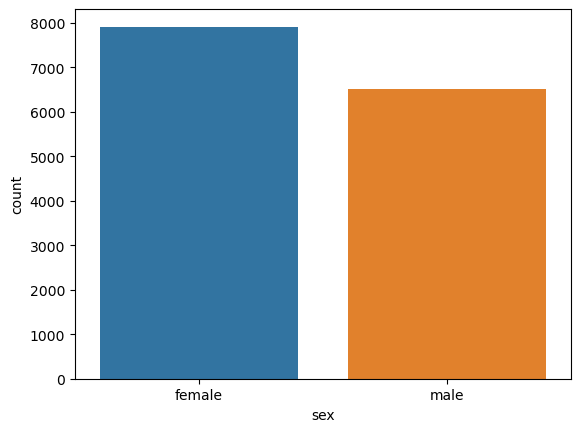

In [17]:
# 빈도를 막대 그래프로 표현
sns.countplot(data=welfare, x = 'sex')

---

### 1. 월급 변수 검토

In [18]:
welfare['income'].dtype

dtype('float64')

In [19]:
welfare['income'].describe()

count    4534.000000
mean      268.455007
std       198.021206
min         0.000000
25%       150.000000
50%       220.000000
75%       345.750000
max      1892.000000
Name: income, dtype: float64

<Axes: xlabel='income', ylabel='Count'>

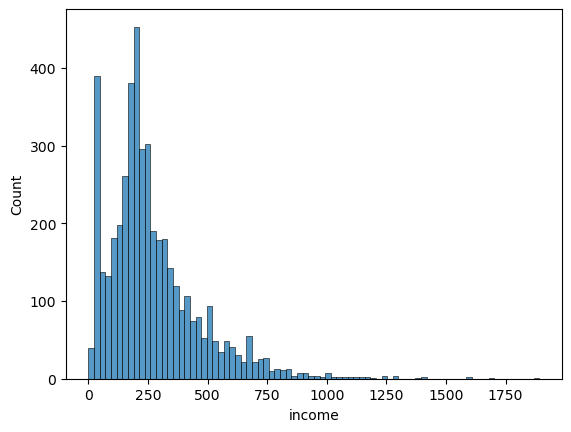

In [20]:
sns.histplot(data=welfare, x = 'income')

### 월급 변수 전처리

In [23]:
# income 변수의 값은 "일한 달의 평균 임금(단위는 만원)", 모름/무응답의 경우 9999
welfare['income'].describe()

count    4534.000000
mean      268.455007
std       198.021206
min         0.000000
25%       150.000000
50%       220.000000
75%       345.750000
max      1892.000000
Name: income, dtype: float64

모름 또는 무응답이 포함되었다면 최대값(max)은 9999일 것임. 그러나 최대값이 1892인 것으로 봤을 때, 모름/무응답에 해당하는 경우는 없음

In [25]:
#결측치 확인
welfare['income'].isna().sum()

9884

- 위 코드의 실행 결과는 9884임. 즉 결측치가 9884개 있음.  
- 간략 통계를 통해 월급의 최소값이 0인 경우가 있고 결측치가 9884개가 있는데 이를 어떻게 해석할 것인지는 생각을 해봐야할 것으로 보임.  
- 일단 결측치가 9884인 것은 직업이 없어서 해당 데이터가 공란(결측치)인 것으로 간주하겠음

### 성별에 따른 월급 차이 분석

In [29]:
sex_income = welfare.dropna(subset =['income']) \
                    .groupby('sex', as_index=False) \
                    .agg(mean_income = ('income', 'mean'))
sex_income

sex  mean_income
0  female   186.293096
1    male   349.037571

월급(income) 평균이 여자는 약 186만원이고 남자는 약 349만원임을 알 수 있음. 남성이 여성 보다 약 163만원 더 많음

### 그래프 만들기

<Axes: xlabel='sex', ylabel='mean_income'>

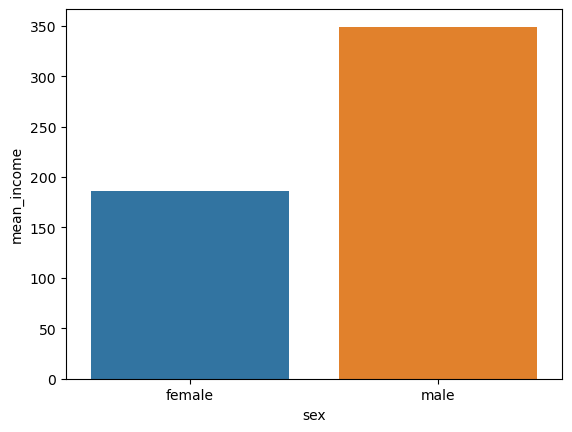

In [32]:
sns.barplot(data=sex_income, x = 'sex', y='mean_income')

---

## 코드 정리

<Axes: xlabel='sex', ylabel='mean_income'>

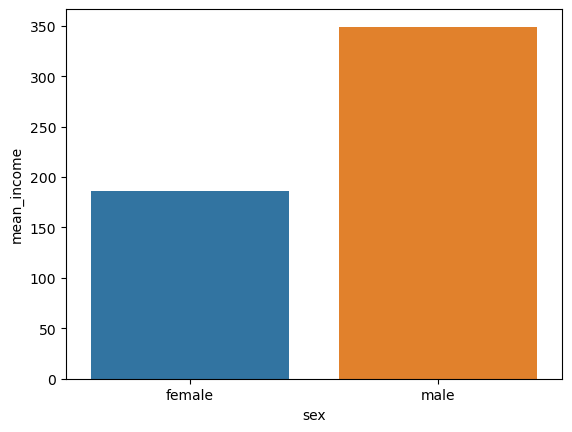

In [35]:
raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()
welfare.head()

# 변수명 바꾸기
welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'p1402_8aq1' : 'income'         # 일을 한 달의 월 평균 임금[단위는 만원]
    }
)  

# 변수 검토 및 전처리
# 특이 사항 없어서 생략하고 성별(sex)의 값 1, 2를 'male'과 'female'로 변경
welfare['sex'] = np.where(welfare['sex'] == 1, 'male', 'female')

# 성별에 따른 월급 차이 분석
sex_income = welfare.dropna(subset =['income']) \
                    .groupby('sex', as_index=False) \
                    .agg(mean_income = ('income', 'mean'))

# 그래프로 시각화
sns.barplot(data=sex_income, x = 'sex', y='mean_income')

## 9-3 나이와 월급의 관계 - 몇 살 때 월급을 가장 많이 받을까?

### 변수 검토하기
나이와 월급(income)을 기반으로 분석을 해야겠습니다. 월급(income) 변수 대해서는 이전 분석에서 살펴 보았고 특이사항이 없었습니다. 
그럼 나이에 대해 변수 검토부터 시작하려고 합니다. 그런데 주어진 데이터(프레임)에는 나이 변수가 없습니다. 나이와 관계된 출생년도(birth) 변수를 검토하고 출생년도(birth) 변수를 근거로 나이(age) (파생)변수를 생성할 생각입니다.

In [37]:
raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()
welfare.head()

# 변수명 바꾸기
welfare = welfare.rename(
    columns = {
        'h14_g4'     : 'birth',         # 태어난 년도
        'p1402_8aq1' : 'income'         # 일을 한 달의 월 평균 임금[단위는 만원]
    }
)  

### 변수 살펴 보기

In [38]:
welfare['birth'].dtypes

dtype('float64')

In [42]:
welfare['birth'].describe()

count    14418.000000
mean      1969.280205
std         24.402250
min       1907.000000
25%       1948.000000
50%       1968.000000
75%       1990.000000
max       2018.000000
Name: birth, dtype: float64

<Axes: xlabel='birth', ylabel='Count'>

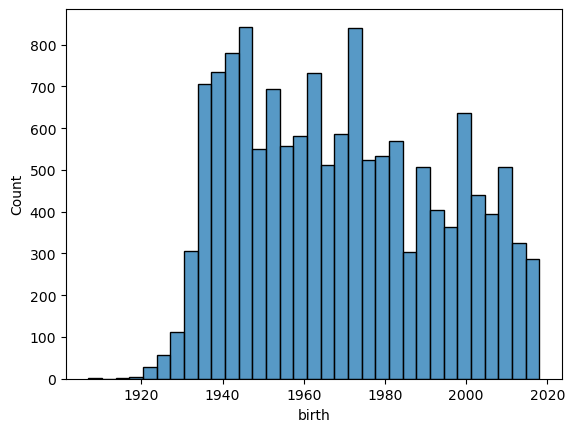

In [41]:
sns.histplot(data=welfare, x='birth')

### 전처리 

In [43]:
# birth의 값 범위는 1900~2014이며 모름/무응답은 9999임
# 아래 코드의 출력 결과를 보면 birth의 값 범위를 벗어난 데이터가 있음. max = 2018. 이 데이터는 정상으로 간주하겠음. 따라서 이상치가 없다고 판단!
welfare['birth'].describe()

count    14418.000000
mean      1969.280205
std         24.402250
min       1907.000000
25%       1948.000000
50%       1968.000000
75%       1990.000000
max       2018.000000
Name: birth, dtype: float64

In [44]:
# 결측치 조사
welfare['birth'].isna().sum()

0

### 파생변수 만들기
출생년도(birth) 변수를 이용하여 나이 값을 갖는 파생 변수 age를 만들겠음
주어진 데이터는 2019년에 조사가 진행되었음으로